## 멀티 에이전트 슈퍼바이저(Multi-agent supervisor)

이 튜토리얼에서는 LangGraph를 활용하여 다중 에이전트 시스템을 구축하고, 에이전트 간 작업을 효율적으로 조정하고 감독자(Supervisor)를 통해 관리하는 방법을 살펴봅니다.
여러 에이전트를 동시에 다루며, 각 에이전트가 자신의 역할을 수행하도록 관리하고, 작업 완료 시 이를 적절히 처리하는 과정을 다룹니다.

- 관련 자료: https://wikidocs.net/270690

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 1. 작업 에이전트 생성

먼저, 연구 에이전트와 수학 에이전트라는 특수 작업 에이전트를 생성해 보겠습니다:

연구 에이전트는 [Tavily API](https://tavily.com/)를 사용하는 웹 검색 도구에 접근할 수 있습니다.
수학 에이전트는 간단한 수학 도구(덧셈, 곱셈, 나눗셈)에 접근할 수 있습니다.

### 연구 에이전트
웹 검색을 위해 `langchain-tavily`의 [`TavilySearch`](https://python.langchain.com/api_reference/tavily/tavily_search/langchain_tavily.tavily_search.TavilySearch.html) 도구를 사용할 것입니다:

In [2]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("서울시의 시장은 누구입니까?")

print(web_search_results["results"][0]["content"])

| ▲ 오세훈 서울시장이 2025년 2월26일 서울 중구 서울시청에서 열린 제4회 서울시 안보포럼 ‘트럼프 2기, 한반도 안보의 길을 묻다’에서 환영사를 하고 있다. △서울시 공식 슬로건 ‘Seoul, my soul(서울, 마이 소울)’ 내걸어 오세훈은 2023년 8월16일 박원순 전 서울시장 때 선정된 서울시 공식 슬로건 ‘I·SEOUL·U(아이서울유)’를 ‘Seoul, my soul(서울, 마이 소울)’로 바꿨다. △4‧7재보선에서 서울시장 당선 오세훈은 2021년 4월7일 박원순 전 시장의 유고로 치러진 서울시장 보궐선거에서 국민의힘 후보로 출마한 뒤 당선돼 10년 만에 서울시장에 복귀했다. 오세훈은 2021년 4월 서울시장 보궐선거를 앞두고 명태균씨 측에서 실시한 여론조사 비용을 사업가 김한정씨에게 대납하게 한 의혹을 받고 있다. 오세훈은 2021년 4월 서울시장 보궐선거를 앞두고 명태균 측에서 실시한 여론조사 비용을 사업가 김한정에게 대납하게 한 의혹을 받고 있다. | ▲ 오세훈 서울시장이 2025년 2월12일 서울 국회 도서관에서 열린 ‘87체제 극복을 위한 지방분권 개헌 토론회’에 입장하고 있다.


개별 작업자 에이전트를 생성하기 위해 LangGraph의 사전 구축된 [에이전트](https://langchain-ai.github.io/langgraph/agents/agents/)를 사용할 것입니다.

In [11]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[web_search],
    prompt=(
        "당신은 연구 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 연구 관련 작업에만 협조하십시오. 수학 문제는 절대 수행하지 마십시오.\n"
        "- 작업 완료 후에는 감독관에게 직접 응답하십시오.\n"
        "- 작업 결과만 응답하십시오. 다른 텍스트는 절대 포함하지 마십시오."
    ),
    name="research_agent",
)

[에이전트를 실행](https://langchain-ai.github.io/langgraph/agents/run_agents/)하여 예상대로 동작하는지 확인해 봅시다.

In [4]:
# 스트리밍 에이전트 출력을 깔끔하게 렌더링하기 위해
# pretty_print_messages 헬퍼를 사용할 것입니다
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
for chunk in research_agent.stream(
    {"messages": [("user", "서울시의 시장은 누구입니까?")]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_ESaHF0VliWe8C3D8plbq8lYR)
 Call ID: call_ESaHF0VliWe8C3D8plbq8lYR
  Args:
    query: 서울특별시장 이름 2024


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "서울특별시장 이름 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ko.wikipedia.org/wiki/%EC%98%A4%EC%84%B8%ED%9B%88", "title": "오세훈 - 위키백과, 우리 모두의 백과사전", "content": "오세훈(吳世勳, 1961년 1월 4일~)은 대한민국의 변호사 출신 정치인이다. 제16대 국회의원을 역임했고, 제33·34·38·39대 서울특별시장이다.", "score": 0.98542, "raw_content": null}, {"url": "https://namu.wiki/w/%EC%98%A4%EC%84%B8%ED%9B%88/%EC%84%9C%EC%9A%B8%EC%8B%9C%EC%A0%95/%EC%A0%9C38%C2%B739%EB%8C%80", "title": "오세훈/서울시정/제38·39대 - 나무위키:대문", "content": "2021년 4월 20일, 오세훈 시장은 피해자에게 현직 시장으로서 진심으로 사과한다고 밝혔다. 또한 재건축, 재개발로 인해 호가가 오르는 현상은 이어져도 이것이

## 수학 에이전트
수학 에이전트 도구에는 [기본 파이썬 함수](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#define-a-tool)를 사용할 것입니다:

In [12]:
def add(a: float, b: float):
    """두 수를 더합니다."""
    return a + b


def multiply(a: float, b: float):
    """두 수를 곱합니다."""
    return a * b


def divide(a: float, b: float):
    """두 수를 나눕니다."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[add, multiply, divide],
    prompt=(
        "당신은 수학 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 오직 수학 관련 작업만 지원하십시오\n"
        "- 작업 완료 후에는 감독관에게 직접 응답하십시오\n"
        "- 오직 작업 결과만 응답하고, 그 외 어떤 텍스트도 포함하지 마십시오."
    ),
    name="math_agent",
)

수학 에이전트를 실행해 보자:

In [7]:
for chunk in math_agent.stream({"messages": [("user", "(3 + 5) × 7은 얼마인가요?")]}):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_WCLmmWc3bb1BWMicIK1FdZR5)
 Call ID: call_WCLmmWc3bb1BWMicIK1FdZR5
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_2qdmGUMc0n7J6UvqLHTMF3Zx)
 Call ID: call_2qdmGUMc0n7J6UvqLHTMF3Zx
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




## 2. `langgraph-supervisor`로 슈퍼바이저 생성하기
다중 에이전트 시스템을 구현하기 위해 사전 구축된 `langgraph-supervisor` 라이브러리의 [`create_supervisor`](https://langchain-ai.github.io/langgraph/reference/supervisor/#langgraph_supervisor.supervisor.create_supervisor)를 사용할 것입니다:

In [13]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1-mini"),
    agents=[research_agent, math_agent],
    prompt=(
        "당신은 두 명의 에이전트를 관리하는 감독관입니다:\n"
        "- research 에이전트: 연구 관련 작업을 이 에이전트에게 할당하십시오\n"
        "- math 에이전트: 수학 관련 작업을 이 에이전트에게 할당하십시오\n"
        "한 번에 한 명의 에이전트에게만 작업을 할당하고, 에이전트를 동시에 호출하지 마십시오.\n"
        "직접 어떤 작업도 수행하지 마십시오."
    ),
    add_handoff_back_messages=True,  # handoff 메시지 추가
    output_mode="full_history",
).compile()

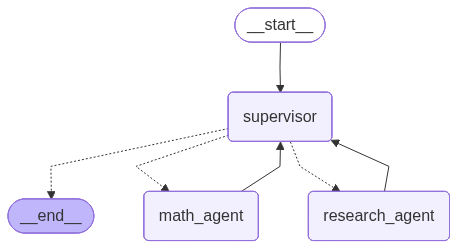

In [9]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

**참고**: 이 코드를 실행하면 슈퍼바이저 에이전트와 작업자 에이전트 간의 흐름을 보여주는 슈퍼바이저 그래프의 시각적 표현이 생성되어 표시됩니다.

이제 두 에이전트 모두를 필요로 하는 쿼리로 실행해 보겠습니다:

- 연구 에이전트는 필요한 GDP 정보를 조회합니다
- 수학 에이전트는 요청된 대로 뉴욕 주 GDP의 비율을 구하기 위해 나눗셈을 수행합니다

In [14]:
query = "2024년 미국 및 뉴욕 주의 국내총생산(GDP)을 찾아보십시오. 뉴욕 주의 GDP가 미국 GDP에서 차지하는 비율은 얼마입니까?"

for chunk in supervisor.stream(
    {"messages": [("user", query)]},
):
    pretty_print_messages(chunk, last_message=True)

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

2024년 미국의 GDP는 약 1.8조 달러 이상이며, 뉴욕 주의 GDP는 약 2.322조 달러입니다. 따라서 뉴욕 주의 GDP는 미국 전체 GDP의 약 13% 내외를 차지합니다. 더 구체적인 계산이나 추가 정보가 필요하시면 알려주세요.




In [15]:
final_message_history = chunk["supervisor"]["messages"]
print(final_message_history)

[HumanMessage(content='2024년 미국 및 뉴욕 주의 국내총생산(GDP)을 찾아보십시오. 뉴욕 주의 GDP가 미국 GDP에서 차지하는 비율은 얼마입니까?', additional_kwargs={}, response_metadata={}, id='b9ec02bc-84a9-418c-adfd-07aad0e4c719'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lvucUParSKm18jMTK9v3K08L', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 198, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPf3HCvjCABB0hUgqqo6Rgxa6tEKA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--101eadd2-2e89-44f2-856a-bf196a3272f0-0', tool_calls=[{'name': 'tr

## 3. 슈퍼바이저 에이전트부터 새로 만들기
이제 동일한 다중 에이전트 시스템을 처음부터 구현해 보겠습니다. 다음을 수행해야 합니다:

1. [감독 에이전트가 개별 에이전트와 통신하는 방식 설정](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#set-up-agent-communication)
2. [감독 에이전트 생성](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#create-supervisor-agent)
3. 감독 에이전트와 작업자 에이전트를 [단일 다중 에이전트 그래프](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#create-multi-agent-graph)로 결합.

### 에이전트 통신 설정

슈퍼바이저 에이전트가 워커 에이전트들과 통신할 수 있는 방식을 정의해야 합니다. 다중 에이전트 아키텍처에서 이를 구현하는 일반적인 방법은 한 에이전트가 다른 에이전트에게 제어권을 넘기는 핸드오프를 사용하는 것입니다. 핸드오프를 통해 다음을 지정할 수 있습니다:

- **destination**: 제어권을 넘길 대상 에이전트
- **payload**: 해당 에이전트에 전달할 정보

우리는 핸드오프 도구를 통해 핸드오프를 구현하고 이 도구들을 관리자 에이전트에 제공할 것입니다: 관리자가 이 도구들을 호출하면, 전체 메시지 기록을 해당 에이전트에 전달하며 제어권을 작업자 에이전트에게 넘깁니다.

In [17]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command
from langchain_core.messages import ToolMessage


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"{agent_name}에게 이관"
    description = description or f"{agent_name}에게 도움을 요청하세요."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = ToolMessage(
            f"{agent_name}에게 성공적으로 이관되었습니다.",
            name=name,
            tool_call_id=tool_call_id,
        )
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="연구자 에이전트에게 작업을 할당합니다.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="수학 에이전트에게 작업을 할당하십시오.",
)

### 슈퍼바이저 에이전트 생성
이제 방금 정의한 핸드오프 도구를 사용하여 슈퍼바이저 에이전트를 생성해 보겠습니다. 

미리 빌드된 [`create_react_agent`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)를 사용할 것입니다:

In [18]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "당신은 두 명의 에이전트를 관리하는 감독관입니다:\n"
        "- research 에이전트: 연구 관련 작업을 이 에이전트에게 할당하십시오\n"
        "- math 에이전트: 수학 관련 작업을 이 에이전트에게 할당하십시오\n"
        "한 번에 한 명의 에이전트에게만 작업을 할당하고, 에이전트를 동시에 호출하지 마십시오.\n"
        "직접 어떤 작업도 수행하지 마십시오."
    ),
    name="supervisor",
)

### 다중 에이전트 그래프 생성

이 모든 것을 종합하여 전체 다중 에이전트 시스템을 위한 그래프를 생성해 보겠습니다. 

슈퍼바이저와 개별 에이전트를 하위 그래프 노드로 추가할 것입니다.

In [ ]:
from langgraph.graph import END

# 다중 에이전트 슈퍼바이저 그래프 정의
supervisor = (
    StateGraph(MessagesState)
    # 참고: `destinations`는 시각화 목적으로만 필요하며 런타임 동작에는 영향을 미치지 않습니다.
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    # 항상 슈퍼바이저에게 보고하십시오
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .set_entry_point("supervisor")
    .compile()
)

작업 에이전트에서 감독자로 명시적인 에지를 추가했음을 확인하십시오. 이는 에이전트가 반드시 제어권을 감독자에게 반환함을 의미합니다. 에이전트가 사용자에게 직접 응답하도록 하려면(즉, 시스템을 라우터로 전환하려면) 이 에지들을 제거할 수 있습니다.

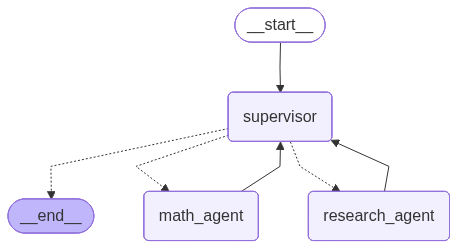

In [22]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

다중 에이전트 그래프가 생성되었으니, 이제 실행해 보겠습니다!

In [23]:
for chunk in supervisor.stream({"messages": [("user", query)]}):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'tools[0].function.name': string does not match pattern. Expected a string that matches the pattern '^[a-zA-Z0-9_-]+$'.", 'type': 'invalid_request_error', 'param': 'tools[0].function.name', 'code': 'invalid_value'}}

## 4. 위임 작업 생성

So far the individual agents relied on interpreting full message history to determine their tasks. An alternative approach is to ask the supervisor to formulate a task explicitly. We can do so by adding a `task_description` parameter to the `handoff_tool` function.



## 상태 정의

In [ ]:
from typing import Annotated
from langgraph.graph.message import MessagesState


class State(MessagesState):
    next_agent: Annotated[str, "다음 작업자"]

## 도구 정의

In [ ]:
from langchain_core.tools import Tool
from langchain_tavily import TavilySearch
from langchain_experimental.utilities import PythonREPL

web_search_tool = TavilySearch(max_results=3)

python_repl = PythonREPL()
python_repl_tool = Tool(
    "python_repl",
    description="파이썬 Shell입니다. 파이썬 명령어를 실행하는 데 사용하세요. 입력은 유효한 파이썬 명령어여야 합니다. 값의 출력을 확인하려면 `print(...)`로 출력해야 합니다.",
    func=python_repl.run,
)

## Research Agent

In [ ]:
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command, Send
from typing import Literal

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search_tool],
    prompt=(
        "귀하는 연구 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 연구 관련 작업만 지원하며, 어떠한 수학 연산도 수행하지 마십시오\n"
        "- 작업을 마치면 감독관에게 직접 응답하십시오\n"
        "- 작업 결과만 응답하고, 그 외의 텍스트는 포함하지 마십시오."
    ),
    name="research_agent",
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    response = research_agent.invoke({"messages": state["messages"]})
    return Command(
        goto="supervisor",
        graph=Command.PARENT,
        update={"messages": response["messages"]},
    )

In [ ]:
research_node({"messages": [("user", "웹에서 랭그래프를 조사하여 알려주세요.")]})

Command(update={'messages': [HumanMessage(content='웹에서 랭그래프를 조사하여 알려주세요.', additional_kwargs={}, response_metadata={}, id='8b216a9c-f0df-4054-92b6-109ebf0588e9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OIojEHJPVnqf2vUyfhb6Y7xE', 'function': {'arguments': '{"query":"랭그래프란 무엇인가"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1347, 'total_tokens': 1369, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_daf5fcc80a', 'id': 'chatcmpl-CPX8w4zbfuOksIfeTDsTd37kxGx9O', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='research_agent', id='run--befbc60a-c16a-4865-98e3-a874a6c2263a-0', tool_calls=[{'name': 'tavily_search', '

## Coder Agent

In [ ]:
coder_prompt = """귀하는 코드 에이전트입니다. 

INSTRUCTIONS:
- 코드 관련 작업에만 도움을 주십시오.
- 작업 완료 후에는 감독관에게 직접 응답하십시오.
- 작업 결과만 답변하고, 그 외 어떤 내용도 포함하지 마십시오.

시각화를 위해 코드에서 반드시 다음 글꼴을 사용하십시오.
```python
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False
```"""

coder_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[python_repl_tool],
    prompt=coder_prompt,
    name="coder_agent",
)


def coder_node(state: State) -> Command[Literal["supervisor"]]:
    response = research_agent.invoke({"messages": state["messages"]})
    return Command(
        goto="supervisor",
        graph=Command.PARENT,
        update={"messages": response["messages"]},
    )

## Supervisor Agent

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import END
from pydantic import BaseModel

supervisor_prompt = """당신은 다음 작업자들을 관리하는 감독관입니다: research, coder 
사용자 요청이 주어졌을 때, 다음에 행동할 작업자를 응답합니다. 
각 작업자는 작업을 수행하고 결과 및 상태를 응답합니다. 
모든 작업을 완료하면, FINISH로 응답하세요."""


class SupervisorResponse(BaseModel):
    """다음 작업자를 선택하거나 작업 완료를 응답합니다."""

    next_agent: Literal["research", "coder", "FINISH"]


supervisor_model = ChatOpenAI(model="gpt-5-mini").with_structured_output(
    SupervisorResponse
)


def supervisor_agent(state: State) -> Command[Literal["research", "coder", END]]:
    response = supervisor_model.invoke(
        [("system", supervisor_prompt)] + state["messages"]
    )
    if response.next_agent == "FINISH":
        return Command(goto=END)
    else:
        return Command(goto=response.next_agent)

In [ ]:
supervisor_agent({"messages": [("user", "웹에서 랭그래프를 조사하여 알려주세요.")]})

Command(goto='research')

## 그래프 작성

In [ ]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(State)
builder.add_node("supervisor", supervisor_agent)
builder.add_node("research", research_node)
builder.add_node("coder", coder_node)
builder.set_entry_point("supervisor")
graph = builder.compile(checkpointer=InMemorySaver())


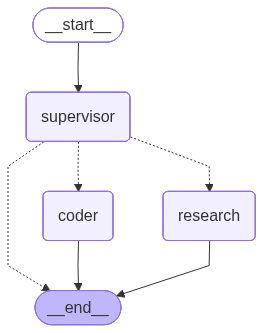

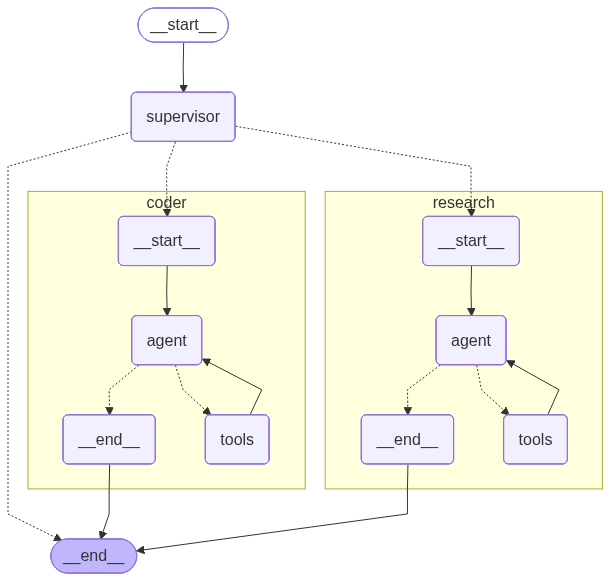

In [ ]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from datetime import datetime
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(
    recursion_limit=20,
    configurable={
        "thread_id": int(datetime.today().timestamp()),
    },
)

query = "2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
for chunk in graph.stream(
    {"messages": [("user", query)]},
    config=config,
    stream_mode="updates",
):
    # pretty_print_messages(chunk, last_message=True)
    for key, values in chunk.items():
        print(f"##### {key.upper()} #####")
        if values and "messages" in values:
            values["messages"][-1].pretty_print()

##### SUPERVISOR #####
##### RESEARCH #####
================================== Ai Message ==================================
Name: research_agent

다음은 2010년~2024년 대한민국의 1인당 GDP(달러, 국제기구 및 IMF/나무위키/TradingEconomics 참고, 일부는 추정치)입니다.

- 2010: 약 22,000
- 2011: 약 24,300
- 2012: 약 25,500
- 2013: 약 26,500
- 2014: 약 27,600
- 2015: 약 27,608
- 2016: 약 29,750
- 2017: 약 31,346
- 2018: 약 31,937
- 2019: 약 33,491
- 2020: 약 35,030
- 2021: 약 36,752
- 2022: 약 38,612
- 2023: 약 34,121 (TradingEconomics, 실제 수치 변동 있음)
- 2024: 약 40,631 (IMF, 추정치)

이 데이터를 기반으로 연도(x축)와 1인당 GDP(달러, y축)의 선 그래프를 그리면 대한민국 1인당 GDP가 전반적으로 꾸준히 상승해왔음을 알 수 있습니다.

데이터 출처:
- https://namu.wiki/w/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD/GDP
- https://ko.tradingeconomics.com/south-korea/gdp-per-capita

감독관님, 위 데이터로 시각화 가능합니다.
##### SUPERVISOR #####
##### CODER #####
================================== Ai Message ==================================
Name: research_agent

2010~2024년 대한민국 1인당 GDP(미국 달러, IMF 및 TradingEconomics 추정치 포함)는 대체로 꾸준한 증가세를 보입

KeyboardInterrupt: 

## Create supervisor with langgraph-supervisor¶
To implement out multi-agent system, we will use create_supervisor from the prebuilt langgraph-supervisor library:

- 참고: https://langchain-ai.github.io/langgraph/reference/supervisor/#langgraph_supervisor.supervisor.create_supervisor